# Latent features

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from warofwords import Dataset
from warofwords import TrainedWarOfWordsLatent

from warofwords.plotting import sigconf_settings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

LEG = 8
FEAT = 'all_features-latent-text'
BASE = '/Users/kristof/GitHub/parl/public/war-of-words-2/'

## Load data

In [2]:
dossier2title = dict()
with open(f'{BASE}/data/helpers/dossier-titles.json', 'r') as f:
    dossier2title = json.load(f)

In [3]:
model_path = f'{BASE}/2-training/trained-models/ep{LEG}-{FEAT}.fit'
model = TrainedWarOfWordsLatent.load(model_path)
vec = model._vec
parameters = model.parameters
features = parameters._features

In [4]:
meps = parameters._features.get_group('mep')
doss = parameters._features.get_group('dossier')

## PCA

In [5]:
def get_dossiers(features, vec):
    """Get top (which='top') or bottom (which='bottom') dossiers."""
    doss = features.get_group('dossier')
    return [features.get_name(d) for d in doss], vec[doss]

In [6]:
doss_refs, vec_y = get_dossiers(features, vec)

In [7]:
n_dims = 20
pca = PCA(n_components=n_dims)
pca.fit(vec_y)

PCA(n_components=20)

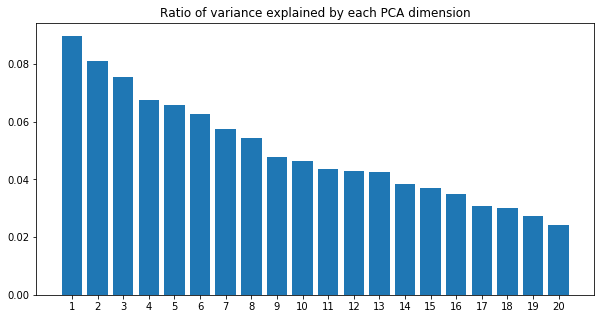

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(n_dims) + 1
ax.bar(x, pca.explained_variance_ratio_)
ax.set_title("Ratio of variance explained by each PCA dimension")
ax.set_xticks(x)
plt.show()

In [9]:
def plot_pca(pca, vec_y, doss_refs, dim, which, n=10):
    """Order: which='top' or which='bottom'"""
    coords = pca.transform(vec_y)
    # Sorted according to coordinate along one PCA dimension.
    idx = np.argsort(coords[:, dim])
    # Get order.
    if which == 'top':
         rank = idx[::-1][:n]
    elif which == 'bottom':
         rank = idx[:n][::-1]
    # Plot top-n.
    for i in rank:
        ref = doss_refs[i]
        title = dossier2title[ref]
        print(f'{coords[i, dim]:+.3f} {ref:<10} {title}\n')

In [10]:
plot_pca(pca, vec_y, doss_refs, dim=0, which='top')

+1.882 A8-0199-2015 Protection of undisclosed know-how and business information (trade secrets) against their unlawful acquisition, use and disclosure

+1.632 A8-0409-2018 Establishing the Connecting Europe Facility

+1.277 A8-0412-2018 Establishing the European Defence Fund

+1.138 CULT-AD(2017)595592 Rules on the exercise of copyright and related rights applicable to certain online transmissions of broadcasting organisations and retransmissions of television and radio programmes

+1.124 A8-0057-2018 Proposal for a Directive of the European Parliament and of the Council to empower the competition authorities of the Member States to be more effective enforcers and to ensure the proper functioning of the internal market

+0.922 LIBE-AD(2018)620997 Import of cultural goods

+0.754 A8-0442-2018 Rules facilitating the use of financial and other information for the prevention, detection, investigation or prosecution of certain criminal offences

+0.735 A8-0355-2018 Transparent and predictab

In [11]:
plot_pca(pca, vec_y, doss_refs, dim=0, which='bottom')

-0.705 A8-0438-2018 Re-use of public sector information (recast)

-0.747 AGRI-AD(2017)604833 Promotion of the use of energy from renewable sources (recast)

-0.770 AFET-AD(2018)612300 Establishing the European Defence Industrial Development Programme aiming at supporting the competitiveness and innovative capacity of the EU defence industry

-0.986 A8-0278-2018 Pan-European Personal Pension Product (PEPP)

-1.196 A8-0482-2018 Establishing the InvestEU Programme

-1.228 A8-0238-2016 Prospectus to be published when securities are offered to the public or admitted to trading

-1.259 A8-0318-2017 European Electronic Communications Code (Recast)

-1.267 A8-0295-2018 Prudential supervision of investment firms

-1.432 A8-0198-2017 Extension of the duration of the European Fund for Strategic Investments as well as the introduction of technical enhancements for that Fund and the European Investment Advisory Hub

-1.485 A8-0011-2019 European Union macro-prudential oversight of the financial syst

In [12]:
plot_pca(pca, vec_y, doss_refs, dim=1, which='top')

+2.005 A8-0318-2017 European Electronic Communications Code (Recast)

+1.244 A8-0068-2019 Justice programme

+1.166 A8-0483-2018 Low carbon benchmarks and positive carbon impact benchmarks

+1.058 A8-0025-2015 Amendment to the fuel quality directive and the renewable energy directive (Indirect Land Use Change)

+0.920 A8-0305-2017 Body of European Regulators for Electronic Communications

+0.883 A8-0037-2018 Establishing the European Defence Industrial Development Programme aiming at supporting the competitiveness and innovative capacity of the EU defence industry

+0.844 A8-0363-2018 Disclosures relating to sustainable investments and sustainability risks

+0.742 A8-0288-2015 Zootechnical and genealogical conditions for trade in and imports into the Union of breeding animals and their germinal products

+0.710 ENVI-AD(2018)630616 Low carbon benchmarks and positive carbon impact benchmarks

+0.702 A8-0313-2017 Protection of individuals with regard to the processing of personal data by 

In [13]:
plot_pca(pca, vec_y, doss_refs, dim=1, which='bottom')

-0.661 EMPL-AD(2015)549263 European Fund for Strategic Investments

-0.662 A8-0227-2018 Increase of the financial envelope of the Structural Reform Support Programme and adapt its general objective

-0.669 A8-0211-2017 Financial rules applicable to the general budget of the Union

-0.717 CULT-AD(2017)592366 Addressing geo-blocking and other forms of discrimination based on customers' nationality, place of residence or place of establishment within the internal market

-0.726 A8-0199-2015 Protection of undisclosed know-how and business information (trade secrets) against their unlawful acquisition, use and disclosure

-0.746 LIBE-AD(2017)604830 Copyright in the Digital Single Market

-0.882 A8-0148-2015 Personal protective equipment

-0.955 A8-0482-2018 Establishing the InvestEU Programme

-1.313 A8-0278-2018 Pan-European Personal Pension Product (PEPP)

-1.557 A8-0139-2015 European Fund for Strategic Investments



## t-SNE

In [15]:
def plot_tsne(pca, vec_y, perplexity, seed=0, n=10):
    coords = pca.transform(vec_y)
    dims = [0, 1]
    # Get dossiers (avoid double counting).
    idx = set()
    for dim in dims:
        idx.update(np.argsort(coords[:,dim])[::-1][:n])
        idx.update(np.argsort(coords[:,dim])[:n])
    idx = np.array(list(idx))
    print(f'Keeping {len(idx)} dossiers for projection')
    
    # Compute t-SNE
    tsne = TSNE(perplexity=perplexity, random_state=seed)
    embed = tsne.fit_transform(vec_y[idx,:])
    plt.scatter(embed[:, 0],embed[:,1])
    plt.show()
    
    return embed, coords, idx


def display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi):
    for i, (x, y) in zip(idx, embed):
        cond_x = (x < x_hi) and (x > x_lo)
        cond_y = (y < y_hi) and (y > y_lo)
        if cond_x and cond_y:
            ref = doss_refs[i]
            title = dossier2title[ref]
            print(f'{x:+.0f} {y:+.0f} {ref:<10} {title}\n')

Seed: 3
Perplexity: 3
Keeping 36 dossiers for projection


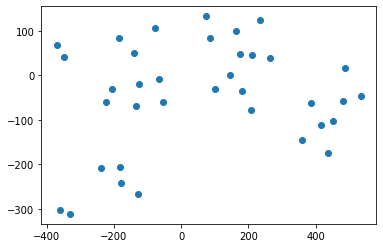

In [16]:
seed = 3
perplexity = 3
print(f'Seed: {seed}')
print(f'Perplexity: {perplexity}')
embed, coords, idx = plot_tsne(pca, vec_y, perplexity=perplexity, seed=seed, n=10)

In [17]:
# Top: Environment and Communications
x_lo, x_hi = -400, 0
y_lo, y_hi = -100, 200
display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi)

-350 +42 A8-0483-2018 Low carbon benchmarks and positive carbon impact benchmarks

-225 -59 ENVI-AD(2018)630616 Low carbon benchmarks and positive carbon impact benchmarks

-206 -30 A8-0025-2015 Amendment to the fuel quality directive and the renewable energy directive (Indirect Land Use Change)

-55 -61 A8-0037-2018 Establishing the European Defence Industrial Development Programme aiming at supporting the competitiveness and innovative capacity of the EU defence industry

-67 -8 A8-0305-2017 Body of European Regulators for Electronic Communications

-77 +106 A8-0068-2019 Justice programme

-184 +84 A8-0318-2017 European Electronic Communications Code (Recast)

-124 -19 A8-0313-2017 Protection of individuals with regard to the processing of personal data by the Union institutions, bodies, offices and agencies and on the free movement of such data

-134 -68 A8-0438-2018 Re-use of public sector information (recast)

-142 +50 A8-0288-2015 Zootechnical and genealogical conditions for trad

In [22]:
# Top-center: Defense and protection
x_lo, x_hi = 0, 300
y_lo, y_hi = -100, 200
display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi)

+264 +39 A8-0199-2015 Protection of undisclosed know-how and business information (trade secrets) against their unlawful acquisition, use and disclosure

+209 -79 A8-0412-2018 Establishing the European Defence Fund

+180 -35 CULT-AD(2017)595592 Rules on the exercise of copyright and related rights applicable to certain online transmissions of broadcasting organisations and retransmissions of television and radio programmes

+86 +83 A8-0442-2018 Rules facilitating the use of financial and other information for the prevention, detection, investigation or prosecution of certain criminal offences

+74 +133 A8-0057-2018 Proposal for a Directive of the European Parliament and of the Council to empower the competition authorities of the Member States to be more effective enforcers and to ensure the proper functioning of the internal market

+146 +1 A8-0244-2016 Establishing an EU common list of safe countries of origin for the purposes of common procedures for granting and withdrawing interna

In [25]:
# Top-right: Investment and Development
x_lo, x_hi = 300, 600
y_lo, y_hi = -200, 100
display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi)

+488 +17 A8-0238-2016 Prospectus to be published when securities are offered to the public or admitted to trading

+360 -145 LIBE-AD(2017)604830 Copyright in the Digital Single Market

+385 -62 EMPL-AD(2015)549263 European Fund for Strategic Investments

+416 -112 A8-0227-2018 Increase of the financial envelope of the Structural Reform Support Programme and adapt its general objective

+451 -104 CULT-AD(2017)592366 Addressing geo-blocking and other forms of discrimination based on customers' nationality, place of residence or place of establishment within the internal market

+535 -46 A8-0198-2017 Extension of the duration of the European Fund for Strategic Investments as well as the introduction of technical enhancements for that Fund and the European Investment Advisory Hub

+438 -174 A8-0139-2015 European Fund for Strategic Investments

+482 -58 A8-0148-2015 Personal protective equipment



In [28]:
# Bottom-left: Business and Innovation
x_lo, x_hi = -400, -100
y_lo, y_hi = -400, -100
display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi)

-362 -304 A8-0295-2018 Prudential supervision of investment firms

-237 -209 A8-0278-2018 Pan-European Personal Pension Product (PEPP)

-182 -206 AGRI-AD(2017)604833 Promotion of the use of energy from renewable sources (recast)

-180 -243 AFET-AD(2018)612300 Establishing the European Defence Industrial Development Programme aiming at supporting the competitiveness and innovative capacity of the EU defence industry

-129 -267 A8-0482-2018 Establishing the InvestEU Programme

-330 -312 A8-0011-2019 European Union macro-prudential oversight of the financial system and establishing a European Systemic Risk Board



In [40]:
clusters = {
   # Environment and Communications
    'ec': 0,  
   # Defense and Protection
    'dp': 1,  
   # Investment and Development
    'id': 2,  
   # Business and Innovation
    'bi': 3,  
   # Others
    'ot': 4,  
}


ref2cluster = {
    # Top-left: Environment and Communications
    'A8-0483-2018': 'ec', # Low carbon benchmarks and positive carbon impact benchmarks
    'ENVI-AD(2018)630616': 'ec', # Low carbon benchmarks and positive carbon impact benchmarks
    'A8-0025-2015': 'ec', # Amendment to the fuel quality directive and the renewable energy directive (Indirect Land Use Change)
    'A8-0037-2018': 'ot', # Establishing the European Defence Industrial Decelopment Programme aiming at supporting the competitiveness and innovative capacity of the EU defence industry
    'A8-0305-2017': 'ec', # Body of European Regulators for Electronic Communications
    'A8-0068-2019': 'ec', # Justice programme
    'A8-0318-2017': 'ec', # European Electronic Communications Code (Recast)
    'A8-0313-2017': 'ec', # Protection of individuals with regard to the processing of personal data by the Union institutions, bodies, offices and agencies and on the free movement of such data
    'A8-0438-2018': 'ec', # Re-use of public sector information (recast)
    'A8-0288-2015': 'ec', # Zootechnical and genealogical conditions for trade in and imports into the Union of breeding animals and their germinal products
    'A8-0363-2018': 'ec', # Disclosures relating to sustainable investments and sustainability risks
     # Top-center cluster: Defense and Protection
    'A8-0199-2015': 'dp', # Protection of undisclosed know-how and business information (trade secrets) against their unlawful acquisition, use and disclosure
    'A8-0412-2018': 'dp', # Establishing the European Defence Fund
    'CULT-AD(2017)595592': 'dp', # Rules on the exercise of copyright and related rights applicable to certain online transmissions of broadcasting organisations and retransmissions of telecision and radio programmes
    'A8-0442-2018': 'dp', # Rules facilitating the use of financial and other information for the precention, detection, investigation or prosecution of certain criminal offences
    'A8-0057-2018': 'dp', # Proposal for a Directive of the European Parliament and of the Council to empower the competition authorities of the Member States to be more effective enforcers and to ensure the proper functioning of the internal market
    'A8-0244-2016': 'dp', # Establishing an EU common list of safe countries of origin for the purposes of common procedures for granting and withdrawing international protection
    'A8-0211-2017': 'ot', # Financial rules applicable to the general budget of the Union
    'A8-0018-2018': 'dp', # Establishing a centralised system for the identification of Member States holding conviction information on third country nationals and stateless persons (TCN) to supplement and support the European Criminal Records Information System (ECRIS-TCN system)
    'A8-0355-2018': 'dp', # Transparent and predictable working conditions in the European Union
    'A8-0409-2018': 'ot', # Establishing the Connecting Europe Facility
    'LIBE-AD(2018)620997': 'dp', # Import of cultural goods
    # Top-right cluster: Investment and Decelopment
    'A8-0238-2016': 'id', # Prospectus to be published when securities are offered to the public or admitted to trading
    'LIBE-AD(2017)604830': 'id', # Copyright in the Digital Single Market
    'EMPL-AD(2015)549263': 'id', # European Fund for Strategic Investments
    'A8-0227-2018': 'id', # Increase of the financial envelope of the Structural Reform Support Programme and adapt its general objective
    'CULT-AD(2017)592366': 'id', # Addressing geo-blocking and other forms of discrimination based on customers' nationality, place of residence or place of establishment within the internal market
    'A8-0198-2017': 'id', # Extension of the duration of the European Fund for Strategic Investments as well as the introduction of technical enhancements for that Fund and the European Investment Advisory Hub
    'A8-0139-2015': 'id', # European Fund for Strategic Investments
    'A8-0148-2015': 'ot', # Personal protective equipment
    # Bottom-left cluster: Business and Innovation
    'A8-0295-2018': 'bi', # Prudential supervision of investment firms
    'A8-0278-2018': 'bi', # Pan-European Personal Pension Product (PEPP)
    'AGRI-AD(2017)604833': 'bi', # Promotion of the use of energy from renewable sources (recast)
    'AFET-AD(2018)612300': 'bi', # Establishing the European Defence Industrial Decelopment Programme aiming at supporting the competitiveness and innovative capacity of the EU defence industry
    'A8-0482-2018': 'bi', # Establishing the InvestEU Programme
    'A8-0011-2019': 'bi', # European Union macro-prudential oversight of the financial system and establishing a European Systemic Risk Board
}    


colors = {
    'dp': 'C3',
    'bi': 'C1',
    'ec': 'C2',
    'id': 'C0',
    'ot': 'lightgray',
}

markers = {
    'dp': 'X',
    'bi': 's',
    'ec': 'v',
    'id': 'o',
    'ot': '.',
}

labels = [
    r'E\&C',
    r'D\&P',
    r'I\&D',
    r'B\&I',
    r'Others',
]

## Plot for paper

Sigconf settings loaded!


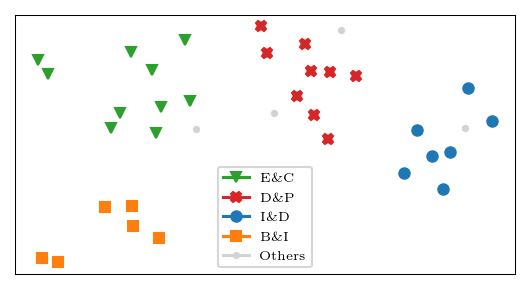

In [44]:
sigconf_settings()
fig, ax = plt.subplots(figsize=(3.6, 2.0))

lines = dict()

for i, (x, y) in zip(idx, embed):
    ref = doss_refs[i]
    cluster = ref2cluster[ref]
    line = ax.plot(x, y, color=colors[cluster], marker=markers[cluster], markersize=5)
    if cluster not in line:
        lines[cluster] = line[0]
    
handles = [lines['ec'],
           lines['dp'],
           lines['id'],
           lines['bi'],
           lines['ot']]



legend = plt.legend(handles, labels,
           loc='lower center',
           frameon=True,
           fontsize='x-small',
#            labelspacing=.2,
#            bbox_to_anchor=(0.52,0.78)
          )
# Change the marker size manually for both lines.
# for handle in legend.legendHandles:
#     handle._legmarker.set_markersize(4)

plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,        # tickcs on the left edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False, # labels along the bottom edge are off
    labelleft=False) # labels along the bottom edge are off
# plt.title('t-SNE visualization of latent feature y_i')
plt.tight_layout()
plt.savefig('figures/tsne.pdf', bbox_inches='tight')
plt.show()

### Generate t-SNE plots for visual inspection

In [ ]:
ps = [4]
# 3: 3
# 4: 10
ss = list(range(9, 11))
for p, s in product(ps, ss):
    print(f'Seed: {s} - Perplexity: {p}')
    embed, coords, _ = plot_tsne(pca, vec_y, perplexity=p, seed=s, n=10)